# Cost-Optimal Task Scheduling in Battery Assisted Mobile Edge Computing

## Baseline

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[\sum_{j\in\mathcal{B},j\neq i}\frac{p_i c_i^G}{\mu_i}x_{ji} + \sum_{j\in\mathcal{B},j\neq i}\left(c_{ij}-\frac{p_i c_i^G}{\mu_i}\right)x_{ij}\right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \frac{p_i c_i^G}{\mu_i}\quad b_{ij}=\left(c_{ij}-\frac{p_i c_i^G}{\mu_i}\right)
$$
The problem is reformualted as follows.
$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}a_i x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} b_{ij}x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

<img src="networkflow.png" alt="Drawing" style="width: 600px;"/>

The weight $(u,v)$ from node $u$ to node $v$ follows
$
w_{uv} = a_v + b_{uv} 
$

## Subproblem 1

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}\left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right)x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right) \quad b_{ij} = \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)
$$
The problem is reformualted the same as the baseline. 


## Subproblem 2

$$
\forall i\in\mathcal{B}  \quad \min_{0\leq P\leq P_i^S} \sum_{i}\left[ \alpha \left(\frac{P}{P_i^S}\right)^{k_p} - P(c_i^G-c_i^D-\pi_i) \right]
$$

Define
$$
g(P) = \alpha \left(\frac{P}{P_i^S}\right)^{k_p} - P(c_i^G-c_i^D-\pi_i)
$$
Let
$$
a_{i} = \frac{\alpha}{(P_i^S)^{k_p}}\quad b_i = (c_i^G-c_i^D-\pi_i)
$$
Then 
$$
g(P) = a_i P^{k_p} -b_i P
$$
And 
$$
g'(P) = a_i k_p P^{k_p-1} - b_i
$$

Therefore
$$
P^{*} = \left\{
\begin{array}{ll}
\left(\frac{b_i}{a_i k_p}\right)^{\frac{1}{k_p-1}} & b_i \geq 0 \\
 0 & \text{otherwise}
\end{array}\right.
$$


In [107]:
%reload_ext autoreload
%autoreload 2
%aimport src

from src.sp1 import NetworkFlowProblem
import numpy as np
from src.optimization import Problem, BaselineProblem

N = 20

lam = np.random.uniform(low=20, high=50, size=N).round()
mu = np.random.uniform(low=1, high=5, size=N).round()
p = np.ones(N) 
cG = np.random.uniform(low=0.5, high=2, size=N).round()
cD = np.ones(N) / 3
C = np.random.randint(0,10,size = (N,N))*0.1
# alpha = 0.2
kp = 2
pS = np.ones(N) * 50

obj_list = []
obj_baseline_list = []
for alpha in [0.2]:

    problem = Problem(alpha=alpha, kp=kp, lam=lam, mu=mu, p=p, cG=cG, cD=cD, pS=pS, C=C)
    baseline = BaselineProblem(alpha=alpha, kp=kp, lam=lam, mu=mu, p=p, cG=cG, cD=cD, pS=pS, C=C)   

    obj, pD, X =problem.optimize(max_iter=1000)
    obj_baseline, pD_baseline, X_baseline = baseline.optimize()

    obj_list.append(obj)
    obj_baseline_list.append(obj_baseline)



Objective=2963.2412518444444, best dual=2963.2412518444444
Baseline objective = 4401.05


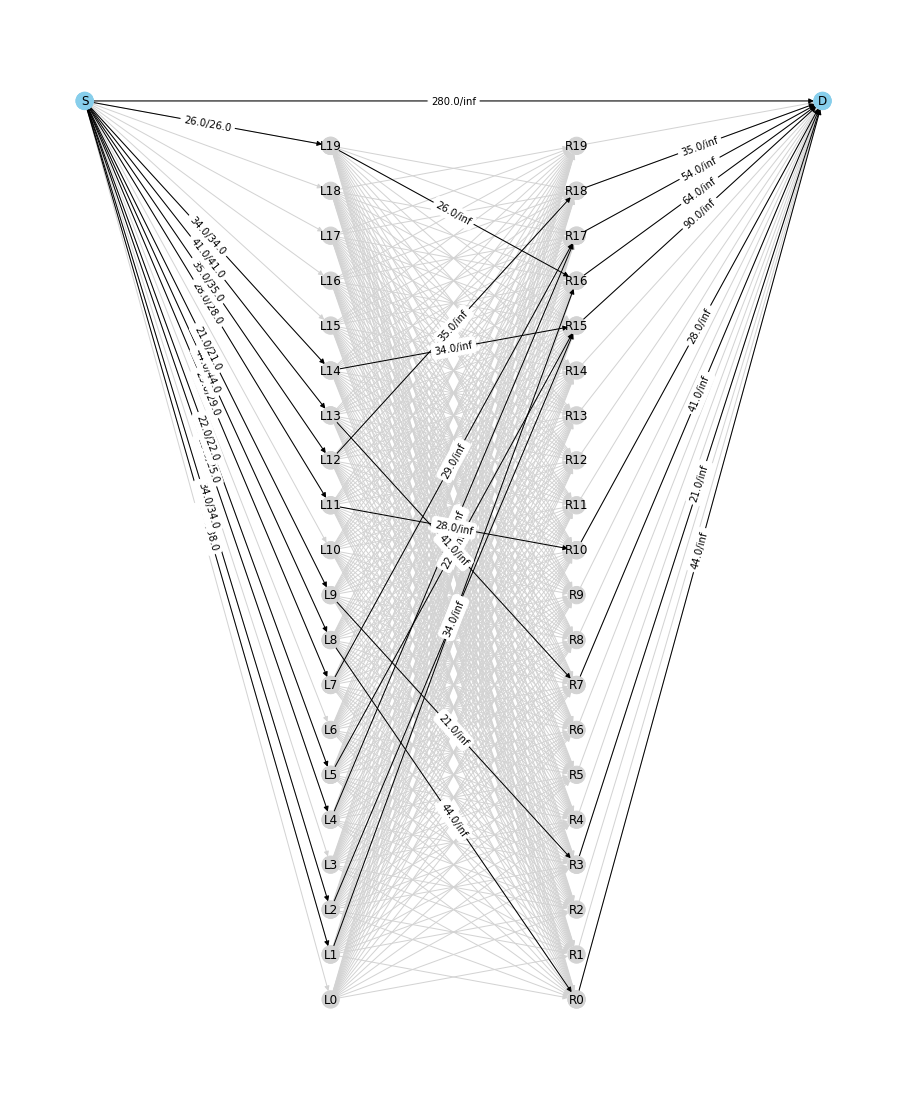

In [103]:
problem.subproblem_1.visualize_flow(figsize=(16,20))

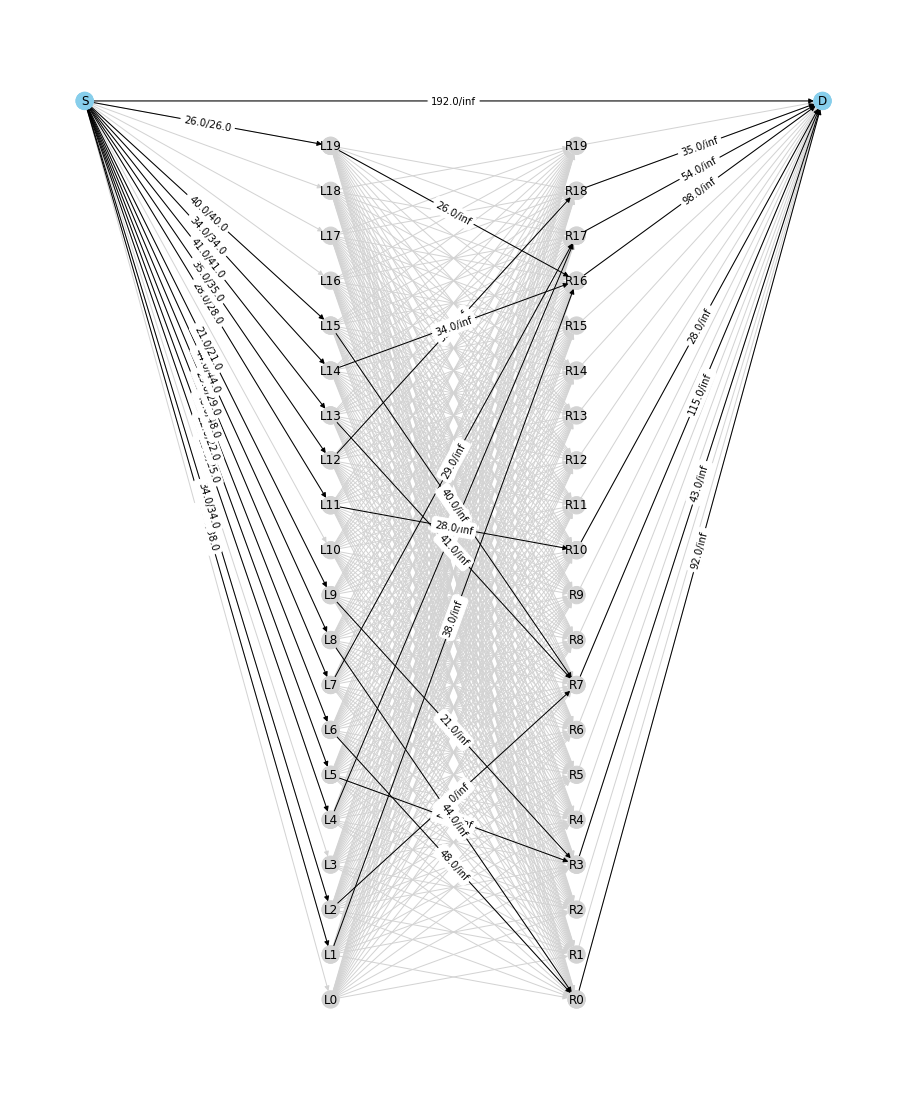

In [104]:
baseline.problem.visualize_flow(figsize=(16,20))

In [21]:
problem.pD

array([ 0.        , 20.5       ,  0.        ,  0.        , 10.        ,
       25.6       , 16.8       ,  0.        , 13.5       ,  0.        ,
        0.        , 10.        ,  0.        ,  0.        ,  0.        ,
        0.        , 15.        , 23.66666667, 18.8       ,  0.        ])

In [22]:
baseline.pD

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])